In [1]:
%load_ext autoreload
%autoreload 1
import os
import sys
sys.path.append("../..")

import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import lightning.pytorch as pl
from tqdm import tqdm

from energy_resolution.sigma_over_e import SigmaOverEComputations, fitSigmaOverE, plotSCAsEllipse, SigmaOverEPlotElement

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
%aimport ml.regression.tracksterProperties
from ml.regression.tracksterProperties import fillHistogramsFromTensorBatches, makeHist
%aimport energy_resolution.sigma_over_e
from energy_resolution.sigma_over_e import SigmaOverEComputations, fitSigmaOverE, plotSCAsEllipse, SigmaOverEPlotElement

2023-06-09 11:31:14.573738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 11:31:14.808169: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND thi

In [2]:
reader_sim = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
reader_data = ClueNtupleReader(reader_sim.version, reader_sim.clueParams, "data")
full_dataset = TensorDataset(*torch.load(os.path.join(reader_sim.pathToFolder, "tracksterProperties.pt")))

In [3]:
totalev = len(full_dataset)
ntrain = int(0.8*totalev)
ntest = totalev - ntrain

ntrainbatch = 200
ntestbatch = 100
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [ntrain, ntest])
full_dataloader = DataLoader(full_dataset, batch_size=1000)
trainloader = DataLoader(train_dataset, batch_size=ntrainbatch, shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=ntestbatch, shuffle=False, num_workers=2)

In [4]:
hidden_size = 10
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
from typing import Any


class TracksterPropModule(pl.LightningModule):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        tracksterProp, trueBeamEnergy = batch[0], batch[1]
        result = torch.squeeze(self.net(tracksterProp))
        loss = nn.functional.mse_loss(result/trueBeamEnergy, torch.ones_like(result)) # Loss is MSE of E_estimate / E_beam wrt to 1
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        tracksterProp, trueBeamEnergy = batch[0], batch[1]
        result_pred = torch.squeeze(self.net(tracksterProp))
        loss = nn.functional.mse_loss(result_pred/trueBeamEnergy, torch.ones_like(result_pred))
        self.log("val_loss", loss)
        return result_pred

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, x) -> Any:
        return torch.squeeze(self.net(x[0]))


module = TracksterPropModule(Model())

In [6]:
module

TracksterPropModule(
  (net): Model(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)

In [7]:
def sigmaOverE(trainer, **trainer_kwargs):
    
    # batches of predictions
    predictions = trainer.predict(dataloaders=full_dataloader, **trainer_kwargs)
    
    h = fillHistogramsFromTensorBatches(predictions, full_dataloader)

    
    E_res_fitResult = fitSigmaOverE(SigmaOverEComputations().compute(h, tqdm_dict=dict(disable=True), multiprocess=True))
    fig = plotSCAsEllipse([SigmaOverEPlotElement(legend="From ML", fitResult=E_res_fitResult)])
    #pl_module.logger.experiment.add_figure("EnergyResolution/Ellipse", fig, trainer.current_epoch)
    return fig

In [8]:

class SigmaOverECallback(pl.Callback):
    def __init__(self, sigma_over_e_dataloader:DataLoader, every_n_epochs=100) -> None:
        super().__init__()
        self.sigma_over_e_dataloader = sigma_over_e_dataloader
        self.every_n_epochs = every_n_epochs
    
    def _fillHistogram(self, pl_module: pl.LightningModule):
        h = makeHist()
        for i, batch in enumerate(self.sigma_over_e_dataloader):
            tracksterProp, trueBeamEnergy, nominalBeamEnergy = batch[0], batch[1], batch[2]
            tracksterProp = pl_module.transfer_batch_to_device(tracksterProp, pl_module.device, dataloader_idx=0)
            pred = pl_module.predict_step(tracksterProp, i)
            h.fill(nominalBeamEnergy.detach().numpy(), pred.detach().cpu().numpy())
        return h
    
    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        if trainer.current_epoch % self.every_n_epochs != 0:
            return
        if trainer.sanity_checking:  # optional skip
            return
        print("Start predicting!")
        try:
            h = self._fillHistogram(pl_module)
            
            E_res_fitResult = fitSigmaOverE(SigmaOverEComputations().compute(h, tqdm_dict=dict(disable=True), multiprocess=True))
            fig = plotSCAsEllipse([SigmaOverEPlotElement(legend="From ML", fitResult=E_res_fitResult)])
            pl_module.logger.experiment.add_figure("Validation/SigmaOverEEllipse", fig, trainer.current_epoch)
        except:
            print("SigmaOverE fit failed")

In [9]:
trainer = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False, callbacks=[
    SigmaOverECallback(full_dataloader, every_n_epochs=1)
])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(module, trainloader, testloader, ckpt_path="/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt", )

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Restoring states from the checkpoint path at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints' to '/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_9/checkpoints', therefore `best_model_score`, `kth_best_model_p

Start predicting!


2023-06-09 11:31:42.108035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:31:42.122760: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:31:42.126779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:31:42.128982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:31:42.131071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:31:42.142605: E tensorflow/compiler/xla/stream_executor/cuda/cuda_drive

W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -4918.26
W MnPosDef Added to diagonal of Error matrix a value 4918.76
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 47.7196 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.000203473
W MnPosDef Added to diagonal of Error matrix a value 0.500204
W VariableMetricBuilder gdel = -235566
Start predicting!


2023-06-09 11:32:31.924347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:32:31.924672: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:32:31.953538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:32:31.958714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:32:31.962224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-09 11:32:31.974696: E tensorflow/compiler/xla/stream_executor/cuda/cuda_drive

W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -3741.94
W MnPosDef Added to diagonal of Error matrix a value 3742.44
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 93.7687 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.000270021
W MnPosDef Added to diagonal of Error matrix a value 0.500271
W VariableMetricBuilder gdel = -1.06307e+06
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 2028.95 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 5.61424
W VariableMetricBuilder gdel = -502.882


In [21]:
h_2d = SigmaOverECallback(full_dataloader)._fillHistogram(module)
h_2d

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  Regular(2000, 0, 350, name='clus3D_mainTrackster_energy_pred', label='Main trackster energy, predicetd by NN (GeV)'),
  storage=Double()) # Sum: 359676.0

Restoring states from the checkpoint path at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
2023-06-09 10:11:21.566243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] co

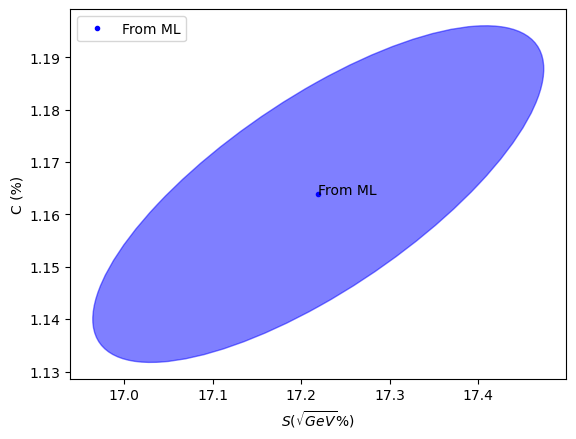

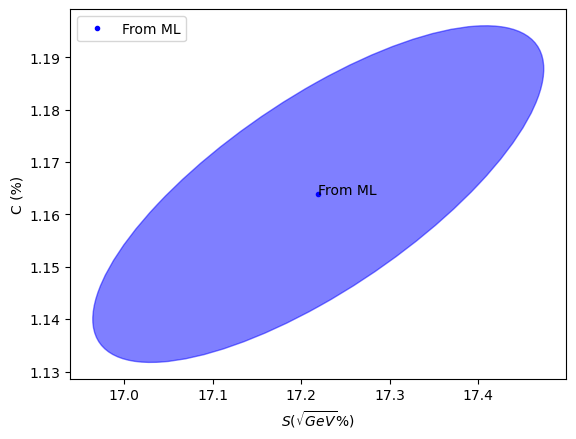

In [9]:
sigmaOverE(model=module, ckpt_path="/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt")

In [9]:
res = trainer.predict(model=module, dataloaders=trainloader, ckpt_path="/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt")
res

Restoring states from the checkpoint path at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/ml/regression/lightning_logs/version_3/checkpoints/epoch=300-step=433139.ckpt
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


[tensor([[ 73.2687],
         [ 82.2990],
         [245.3350],
         [ 20.2717],
         [ 29.1144],
         [ 28.4407],
         [149.3851],
         [ 99.5386],
         [289.4551],
         [185.3467],
         [290.1788],
         [118.1120],
         [121.1964],
         [ 76.1719],
         [ 78.5332],
         [126.0269],
         [ 21.0015],
         [119.8951],
         [199.5837],
         [ 31.1762],
         [ 51.7424],
         [120.6377],
         [291.0060],
         [ 30.0638],
         [115.9409],
         [ 47.6874],
         [119.5070],
         [ 19.6592],
         [ 29.3551],
         [ 51.5577],
         [298.9566],
         [ 48.8206],
         [ 21.1891],
         [247.6118],
         [122.9894],
         [122.4999],
         [ 85.3584],
         [ 81.6978],
         [200.5395],
         [ 53.5401],
         [ 29.1871],
         [116.2404],
         [194.9739],
         [ 29.7886],
         [116.9971],
         [ 80.7807],
         [242.1734],
         [119

In [ ]:
SigmaOverECallback(1).on_train_epoch_end(trainer, module)